# Synthetic data

In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm


In [2]:
import maelstrom

In [3]:
from maelstrom import Maelstrom

In [4]:
from exoplanet import __version__
__version__

'0.1.4'

In [7]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            M = tt.zeros_like(tt.constant(self.time)) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, noise=0.05):
        # Add noise
        self.flux_err = noise * np.std(self.flux_true)
        self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))
        
    @staticmethod
    def quick_star(self, star='dsct', mission='kepler'):
        if star == 'dsct':
            pass

In [59]:
period = 1.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

n_freqs = 1
freqs = [50]
amps = [1]
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs,amps,
                     period, eccen, asini, varpi, tref)

#lc.add_noise(noise=0.5)


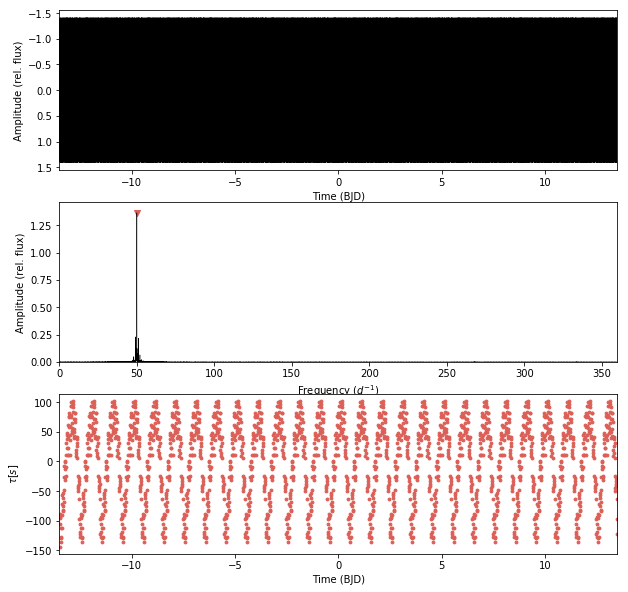

In [72]:
ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
               #max_peaks=1
              )
ms.first_look(segment_size=0.01)

In [73]:
ms.setup_orbit_model(period=5.)
opt = ms.optimize(verbose=True)

success: False
initial logp: 686.0331321330586
final logp: 789.5837869412958


In [24]:
ms.logp(opt)

array(0.)

In [ ]:
period = 5.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

In [74]:
period = np.arange(1,27,1)
asini = np.arange(1,100, 5)

In [34]:
from tqdm import tqdm_notebook as tqdm
time = np.arange(0, 27, 1.0 / (24 * 30))
logp = []
for p in period:
    for a in tqdm(asini):
        eccen = 0.5
        varpi = 1.
        tref = 0.

        n_freqs = 1
        freqs = [50]
        amps = [1]
        

        lc = SyntheticBinary(time, freqs,amps,
                             p, eccen, a, varpi, tref)
        
        ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
               #max_peaks=1
              )
        ms.setup_orbit_model(period=p)
        opt = ms.optimize()
        logp.append(ms.logp(opt))

In [ ]:
from multiprocessing import Pool

from tqdm import tqdm_notebook as tqdm
time = np.arange(0, 27, 1.0 / (24 * 30))
logp = []

period = np.arange(1,27,1)
asini = np.arange(1,100, 5)

def get_logp(asini):
    for p in period:
        eccen = 0.5
        varpi = 1.
        tref = 0.
        n_freqs = 1
        freqs = [50]
        amps = [1]
        lc = SyntheticBinary(time, freqs,amps,
                             p, eccen, asini, varpi, tref)
        ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
               #max_peaks=1
              )
        ms.setup_orbit_model(period=p)
        opt = ms.optimize()
        logp.append(ms.logp(opt))
        
p = Pool(4)
p.map(get_logp, asini)

In [ ]:
from multiprocessing import Pool


def print_val(i):
    return i

p = Pool(4)
a = p.map(print_val, np.arange(1,100))

In [63]:
new_logp = np.array(logp)

In [67]:
plt.contourf?

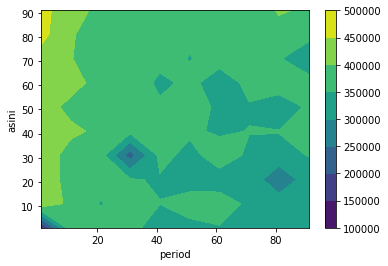

In [70]:
plt.contourf(period, asini, new_logp.reshape(len(period), len(asini)))
plt.xlabel('period')
plt.ylabel('asini')
plt.colorbar()

In [55]:
period

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

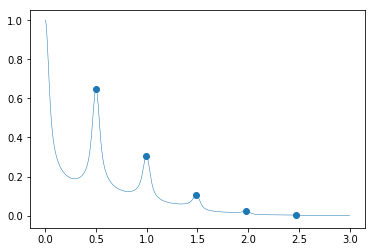

In [229]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]


ac = autocorr(gaussian_filter(amp, 500))
ac /= np.max(ac)

df = freq[1]-freq[0]
llags =  df*np.arange(len(ac))

plt.plot(llags, ac, linewidth=0.5)

pp = find_peaks(ac)[0]

plt.scatter(llags[pp],ac[pp])

In [230]:
np.isclose(np.diff(llags[pp]), np.average(np.diff(llags[pp])), rtol=0.1)

array([ True,  True,  True,  True])

In [204]:
np.isclose?

Text(0, 0.5, 'autocorrelation of power')

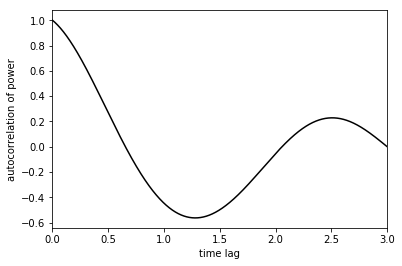

In [18]:
from scipy.ndimage.filters import gaussian_filter

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def find_peaks(z):
    peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
    peak_inds = np.arange(1, len(z)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
    return peak_inds

def acor_function(x):
    x = np.atleast_1d(x)
    n = next_pow_two(len(x))
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= acf[0]
    return acf

def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(freq, amp)

# And the autocorrelation function of a lightly smoothed power spectrum
df = freq[1] - freq[0]
acor = acor_function(gaussian_filter(amp / bkg, 0.5 / df))
lags = df*np.arange(len(acor))
acor = acor[lags < 30]
lags = lags[lags < 30]

# Expected delta_nu: Stello et al (2009)
peak_lags = lags[find_peaks(acor)]

plt.plot(lags, acor, "k")
plt.xlim(lags[0], lags[-1])
plt.xlabel("time lag")
plt.ylabel("autocorrelation of power")

In [7]:
1/period

0.5

In [231]:
from timedelay import TimeDelay
td = TimeDelay(lc.time, lc.flux, freqs=freqs)
td.first_look(segment_size=0.5)

ModuleNotFoundError: No module named 'lightkurve'

In [87]:
est_freq = []
steps = np.arange(1,100,1)
from tqdm import tqdm
for p in tqdm(steps):
    lc = SyntheticBinary(time, freqs,amps,
                     p, eccen, asini, varpi, tref)
    est_freq.append(estimate_frequencies(lc.time, lc.flux, max_peaks=1, optimize_freq=True))

100%|██████████| 99/99 [00:14<00:00,  7.12it/s]


Text(0, 0.5, 'True frequency - estimated')

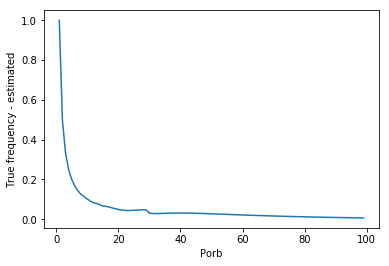

In [88]:
plt.plot(steps, freqs[0]-np.array(est_freq))
plt.xlabel('Porb')
plt.ylabel('True frequency - estimated')
#plt.axhline(350., c='r')
#plt.savefig('wtf.png')

In [42]:
from maelstrom import estimate_frequencies

freqs[0] - estimate_frequencies(lc.time, lc.flux, max_peaks=1, optimize_freq=True)

array([0.00832085])

In [43]:
1/(freqs[0]/period)

0.2857142857142857

TypeError: estimate_frequencies() got an unexpected keyword argument 'optimize_freq'

In [23]:
import pandas as pd
a = pd.Series({'a':["bla", "b", "c", "d"]})

In [33]:
a['a'].str.contains('b')

AttributeError: 'list' object has no attribute 'str'

In [3]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

# Generate the light curve using the `flux` method
time = np.arange(0, 27, 1.0 / (24 * 30))
freq = 300
y = np.zeros(len(time))

period = 10
eccen = 0.5
asini=100.
varpi=1.

with pm.Model() as model:
    M = tt.zeros_like(tt.constant(time)) + 2.0 * np.pi * (tt.constant(time)) / period
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    tau_tens = (- (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))) * (asini / 86400.)
    
    tau_val = eval_in_model(tau_tens)
    true_anom_val = eval_in_model(f)

Text(0, 0.5, 'Time delay (s)')

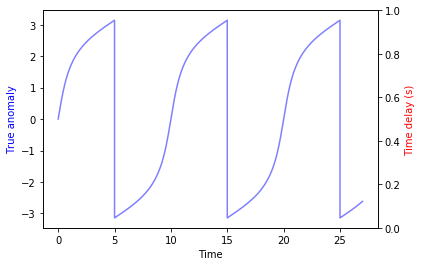

In [4]:
plt.plot(time,true_anom_val, color='b', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('True anomaly', color='b')
new_ax = plt.twinx()
#new_ax.plot(time,tau_val*86400, c='r', alpha=0.5)
new_ax.set_ylabel('Time delay (s)', color='r')
#plt.savefig('weird.png',dpi=150)

100%|██████████| 19440/19440 [00:00<00:00, 515977.03it/s]


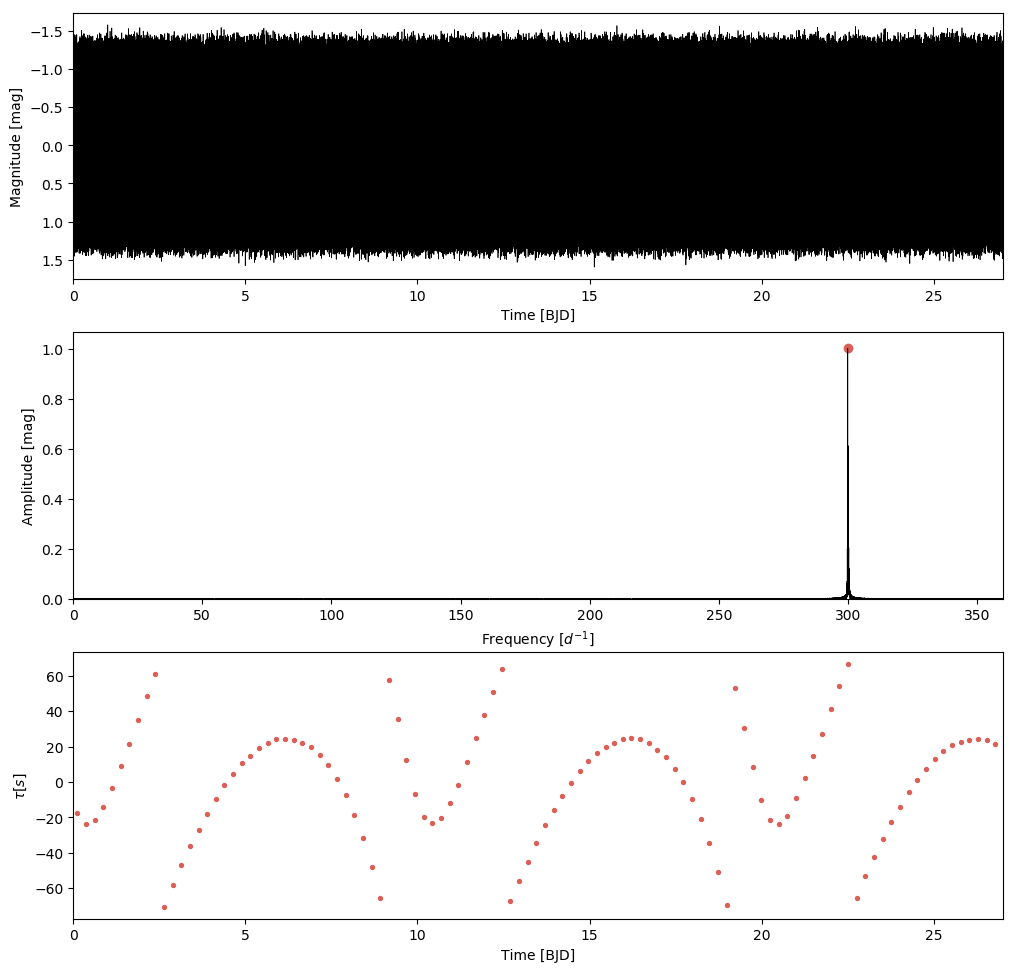

In [73]:
from timedelay import TimeDelay
td = TimeDelay(time, flux, freqs=freq)
td.first_look(segment_size=0.25)

In [4]:
def kepler(Marr, eccarr):
    """Solve Kepler's Equation
    Args:
        Marr (array): input Mean anomaly
        eccarr (array): eccentricity
    Returns:
        array: eccentric anomaly
    """

    conv = 1.0e-12  # convergence criterion
    k = 0.85

    Earr = Marr + np.sign(np.sin(Marr)) * k * eccarr  # first guess at E
    # fiarr should go to zero when converges
    fiarr = ( Earr - eccarr * np.sin(Earr) - Marr)
    convd = np.where(np.abs(fiarr) > conv)[0]  # which indices have not converged
    nd = len(convd)  # number of unconverged elements
    count = 0

    while nd > 0:  # while unconverged elements exist
        count += 1

        M = Marr[convd]  # just the unconverged elements ...
        ecc = eccarr[convd]
        E = Earr[convd]

        fi = fiarr[convd]  # fi = E - e*np.sin(E)-M    ; should go to 0
        fip = 1 - ecc * np.cos(E)  # d/dE(fi) ;i.e.,  fi^(prime)
        fipp = ecc * np.sin(E)  # d/dE(d/dE(fi)) ;i.e.,  fi^(\prime\prime)
        fippp = 1 - fip  # d/dE(d/dE(d/dE(fi))) ;i.e.,  fi^(\prime\prime\prime)

        # first, second, and third order corrections to E
        d1 = -fi / fip
        d2 = -fi / (fip + d1 * fipp / 2.0)
        d3 = -fi / (fip + d2 * fipp / 2.0 + d2 * d2 * fippp / 6.0)
        E = E + d3
        Earr[convd] = E
        fiarr = ( Earr - eccarr * np.sin( Earr ) - Marr) # how well did we do?
        convd = np.abs(fiarr) > conv  # test for convergence
        nd = np.sum(convd is True)

    if Earr.size > 1:
        return Earr
    else:
        return Earr[0]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the light curve using the `flux` method
time = np.arange(0, 27, 1.0 / (24 * 30))
freq = [300,200]
A = [1,0.5]
B = [1,0.5]
y = np.zeros(len(time))

tref = 0.
period = 10
eccen = 0.5
asini=100.
varpi=1

mean_anom = np.zeros_like(time) + 2.0 * np.pi * (time - tp) / period
ecc_anom = kepler(mean_anom, eccen + np.zeros_like(mean_anom))
true_anom = 2.0 * np.arctan2(np.sqrt(1.0+eccen)*np.tan(0.5*ecc_anom),np.sqrt(1.0-eccen) + np.zeros_like(time))
# Here we define how the time delay will be calculated:
tau = -(asini/86400) * (1.0 - np.square(eccen)) * np.sin(true_anom + varpi) / (1.0 + eccen*np.cos(true_anom))

for j, A_j, B_j in zip(freq, A, B):
    omega = 2 * np.pi * j
    y += A_j * np.cos(omega * (time-tau)) + B_j * np.sin(omega * (time-tau))
    

# Add noise
flux_err = 0.05 * np.std(y)
flux = y + flux_err * np.random.randn(len(y))

NameError: name 'tp' is not defined

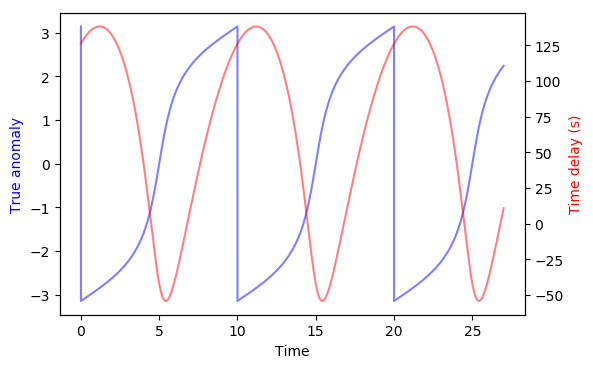

In [106]:
plt.plot(time,true_anom, color='b', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('True anomaly', color='b')
new_ax = plt.twinx()
new_ax.plot(time,tau*86400, c='r', alpha=0.5)
new_ax.set_ylabel('Time delay (s)', color='r')
plt.savefig('weird2.png',dpi=150)

In [142]:
# Comparison

In [5]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

period = 10
eccen = 0.5
asini=100.
varpi=1.

# TESS time sampling
time = np.arange(0, 27, 1.0 / (24 * 30))

with pm.Model() as model:
    M = tt.zeros_like(tt.constant(time)) + 2.0 * np.pi * (tt.constant(time)) / period
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    tau_tens = (- (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1. + eccen*tt.cos(f))) * (asini / 86400.)
    
    tau_val = eval_in_model(tau_tens)
    true_anom_val = eval_in_model(f)
    
mean_anom = np.zeros_like(time) + 2.0 * np.pi * (time) / period
ecc_anom = kepler(mean_anom, eccen + np.zeros_like(mean_anom))
true_anom_python = 2.0 * np.arctan2(np.sqrt(1.0+eccen)*np.tan(0.5*ecc_anom),np.sqrt(1.0-eccen) + np.zeros_like(time))
tau_python = -(asini/86400) * (1.0 - np.square(eccen)) * np.sin(true_anom_python + varpi) / (1.0 + eccen*np.cos(true_anom_python))


(0, 6.597346415513851)

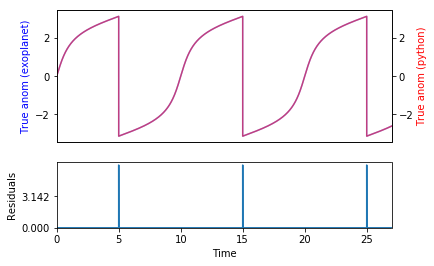

In [6]:
fig, axes = plt.subplots(2,1,gridspec_kw={'height_ratios':[2,1]})
ax = axes[0]
ax.plot(time, true_anom_val, alpha=0.5, c='b')
ax.set_xticks([])
ax.set_ylabel('True anom (exoplanet)', color='blue')
ax.set_xlim(0,time[-1])

ax2 = ax.twinx()
ax2.plot(time, true_anom_python, alpha=0.5, c='r')
ax2.set_ylabel('True anom (python)', color='red')
ax2.set_xlim(0,time[-1])

ax = axes[1]
ax.plot(time, true_anom_val - true_anom_python, 2)
ax.set_ylabel('Residuals')
ax.set_yticks([0,np.pi])
ax.set_xlabel('Time')
ax.set_xlim(0,time[-1])
ax.set_ylim(0, None)

#plt.savefig('residual.png', dpi=150)

Text(0.5, 0, 'Time')

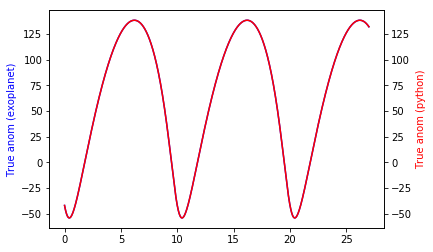

In [7]:
plt.plot(time, tau_val * 86400,c='b')
plt.ylabel('True anom (exoplanet)', color='blue')
ax2 = plt.twinx()
ax2.plot(time, tau_python * 86400, c='r')
ax2.set_ylabel('True anom (python)', color='red')

ax2.set_xlabel('Time')
#plt.savefig('tau_compare.png', dpi=150)

In [164]:
true_anom_val[time==5], true_anom_python[time==5]

(array([0.]), array([-3.14153228]))

In [159]:
tau_val[(time==5)]

array([-0.00048696])

In [181]:
mean_anom[time==5]

array([3.14159265])

In [195]:
mean_anom = np.pi + np.zeros_like(time)
ecc_anom = kepler(mean_anom, eccen + np.zeros_like(mean_anom))
true_anom_python = 2.0 * np.arctan2(np.sqrt(1.0+eccen)*np.tan(0.5*ecc_anom),np.sqrt(1.0-eccen) + np.zeros_like(time))

In [196]:
true_anom_python

array([-3.14153228, -3.14153228, -3.14153228, ..., -3.14153228,
       -3.14153228, -3.14153228])